<a href="https://colab.research.google.com/github/Joh-Ishimwe/Time-Series-Forecasting/blob/master/air_quality_forecasting_notebook_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2


In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head(-10)

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
30661,30662,1.467633,1.110916,-1.699130,-0.441894,-0.069353,-0.137667,2013-07-01 13:00:00,1.448138,-0.732019,-0.522096,172.0
30662,30663,1.467633,1.110916,-1.796514,-0.441894,-0.069353,-0.137667,2013-07-01 14:00:00,-0.690542,1.366085,-0.522096,183.0
30663,30664,1.467633,1.110916,-1.796514,-0.379306,-0.069353,-0.137667,2013-07-01 15:00:00,-0.690542,1.366085,-0.522096,195.0
30664,30665,1.467633,1.110916,-1.796514,-0.441894,-0.069353,-0.137667,2013-07-01 16:00:00,-0.690542,-0.732019,-0.522096,191.0


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])


# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Sort by index to ensure chronological order (important for time series)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

# Handle missing values





- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [ ]:
# Check for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())


Missing values in training data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [ ]:
# Check data types and info
print("\nTrain info:")
train.info()


Train info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       30676 non-null  int64  
 1   DEWP     30676 non-null  float64
 2   TEMP     30676 non-null  float64
 3   PRES     30676 non-null  float64
 4   Iws      30676 non-null  float64
 5   Is       30676 non-null  float64
 6   Ir       30676 non-null  float64
 7   cbwd_NW  30676 non-null  float64
 8   cbwd_SE  30676 non-null  float64
 9   cbwd_cv  30676 non-null  float64
 10  pm2.5    28755 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB


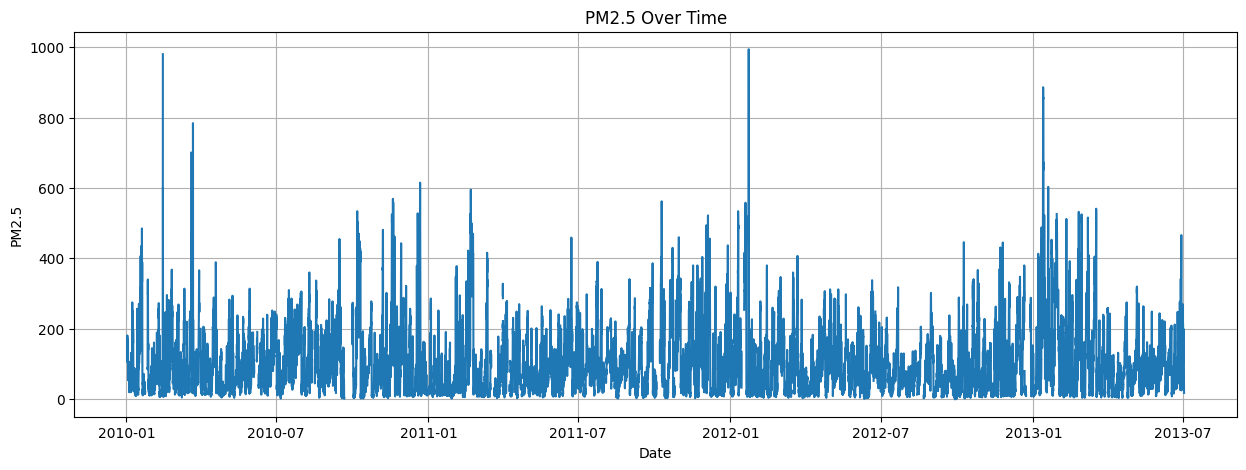

In [ ]:
# Plot PM2.5 over time
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['pm2.5'])
plt.title('PM2.5 Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()

                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353   
2010-01-01 04:00:00   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353   
2010-01-01 05:00:00   6 -1.442309 -1.840273  0.053790 -0.155751 -0.069353   
2010-01-01 06:00:00   7 -1.442309 -1.758296  0.053790 -0.093164 -0.069353   
2010-01-01 07:00:00   8 -1.442309 -1.758296  0.053790 -0.057371 -0.069353   
2010-01-01 08:00:00   9 -1.442309 -1.758296  0.053790  0.005216 -0.069353   
2010-01-01 09:00:00  10 -1.511594 -1.676318  0.053790  0.067804 -0.069353   

                           Ir   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  
dateti

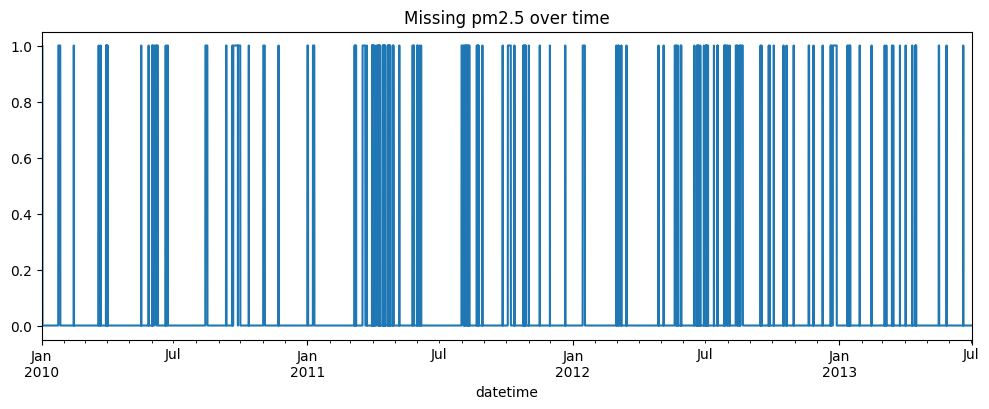

In [ ]:
# Check where the missing values occur
missing = train[train['pm2.5'].isnull()]
print(missing.head(10))
print(missing.tail(10))

# Or plot to see it clearly
import matplotlib.pyplot as plt
train['pm2.5'].isnull().astype(int).plot(figsize=(12, 4), title="Missing pm2.5 over time")
plt.show()


In [ ]:
# Handle missing values

# Step 1: Backfill only the starting block
# train['pm2.5'] = train['pm2.5'].fillna(method='bfill', limit=24)
train['pm2.5'] = train['pm2.5'].fillna(method='ffill')

# Step 2: Time-based interpolation for the rest
train['pm2.5'] = train['pm2.5'].interpolate(method='time')

# Confirm no missing values
print(train['pm2.5'].isnull().sum())


24


<ipython-input-11-3bd8a8908d0e>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['pm2.5'] = train['pm2.5'].fillna(method='ffill')


In [ ]:
# # Feature Engineering
#
# Create new features from the datetime index.
def create_time_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    return df

train = create_time_features(train)
test = create_time_features(test)

print("\nTraining data with new time features:")
print(train.head())


Training data with new time features:
                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353   
2010-01-01 04:00:00   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353   

                           Ir   cbwd_NW   cbwd_SE   cbwd_cv  pm2.5  hour  \
datetime                                                                   
2010-01-01 00:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN     0   
2010-01-01 01:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN     1   
2010-01-01 02:00:00 -0.137667  1.448138 -0.732019 -0.522096    NaN     2   
2010-01-01 03:00:00 -0.137667  1.448138 -

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
# 1. Separate target and features
y_train = train['pm2.5']
# Make sure to include the new features in X_train
X_train = train.drop(['pm2.5', 'No'], axis=1) # Drop 'No' and the target

# Drop 'No' from test set - X_test already has the new features from the step above
X_test = test.drop(['No'], axis=1)

# Ensure both have the same columns before processing (excluding target)
train_cols = X_train.columns
test_cols = X_test.columns
if not train_cols.equals(test_cols):
    X_test = X_test.reindex(columns=train_cols, fill_value=0)
    print("\nWarning: Test set columns reindexed to match training set columns.")

print("\nFeatures for training after adding new features:")
print(X_train.columns)


Features for training after adding new features:
Index(['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'hour', 'dayofweek', 'month', 'quarter', 'year'],
      dtype='object')


In [ ]:
# # Preprocessing Pipeline (Scaling and Encoding)
# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = ['dayofweek', 'month']
# Ensure categorical_features are actually in the DataFrame columns
categorical_features = [col for col in categorical_features if col in X_train.columns]
numerical_features = [col for col in numerical_features if col not in categorical_features]


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Fit the preprocessor on the training data and transform both training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Scale the target variable
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

print("\nShape of processed training features:", X_train_processed.shape)
print("Shape of processed test features:", X_test_processed.shape)
print("Shape of scaled training target:", y_train_scaled.shape)


Shape of processed training features: (30676, 31)
Shape of processed test features: (13148, 31)
Shape of scaled training target: (30676, 1)


In [ ]:
# # Create Time Series Sequences for LSTM


def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the number of time steps (look-back period)
TIME_STEPS = 72

X_lstm, y_lstm = create_sequences(X_train_processed, y_train_scaled, time_steps=TIME_STEPS)

print("\nShape of LSTM input sequences (X_lstm):", X_lstm.shape)
print("Shape of LSTM target (y_lstm):", y_lstm.shape)

# For the test set, I need to create sequences for prediction.

combined_data_processed = np.concatenate((X_train_processed[-TIME_STEPS:], X_test_processed), axis=0)

# Create sequences for the test set
X_test_lstm, _ = create_sequences(combined_data_processed, np.zeros(combined_data_processed.shape[0]), time_steps=TIME_STEPS)


print("\nShape of LSTM input sequences (X_test_lstm) for prediction:", X_test_lstm.shape)


Shape of LSTM input sequences (X_lstm): (30604, 72, 31)
Shape of LSTM target (y_lstm): (30604, 1)

Shape of LSTM input sequences (X_test_lstm) for prediction: (13148, 72, 31)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
# Build LSTM Model Architecture
model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
    Dropout(0.3),
    LSTM(128, return_sequences=False, activation='tanh'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=adam_optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 72, 256)        │       163,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,129 (969.25 KB)

 Trainable params: 248,129 (969.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# # Train the Model with Time Series Split Validation
# Use TimeSeriesSplit for validation
tscv = TimeSeriesSplit(n_splits=5)

# We'll use the last split for training and validation
for train_index, val_index in tscv.split(X_lstm):
    X_train_split, X_val_split = X_lstm[train_index], X_lstm[val_index]
    y_train_split, y_val_split = y_lstm[train_index], y_lstm[val_index]

print(f"\nShape of training split for the last fold: {X_train_split.shape}")
print(f"Shape of validation split for the last fold: {X_val_split.shape}")


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)




Shape of training split for the last fold: (25504, 72, 31)
Shape of validation split for the last fold: (5100, 72, 31)


In [ ]:
# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping],
    validation_data=(X_val_split, y_val_split)
)

Epoch 1/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 205s 250ms/step - loss: 0.0936 - root_mean_squared_error: 0.0998 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1048
Epoch 2/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 211s 262ms/step - loss: 0.0241 - root_mean_squared_error: 0.0741 - val_loss: 0.0182 - val_root_mean_squared_error: 0.0967
Epoch 3/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 263s 263ms/step - loss: 0.0123 - root_mean_squared_error: 0.0683 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0832
Epoch 4/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 255s 254ms/step - loss: 0.0088 - root_mean_squared_error: 0.0654 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0880
Epoch 5/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 270s 264ms/step - loss: 0.0071 - root_mean_squared_error: 0.0638 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0824
Epoch 6/20
797/797 ━━━━━━━━━━━━━━━━━━━━ 262s 264ms/step - loss: 0.0062 - root_mean_squared_error: 0.0635 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0855
Epoch 7/20
797/797 ━━━━━━━━━

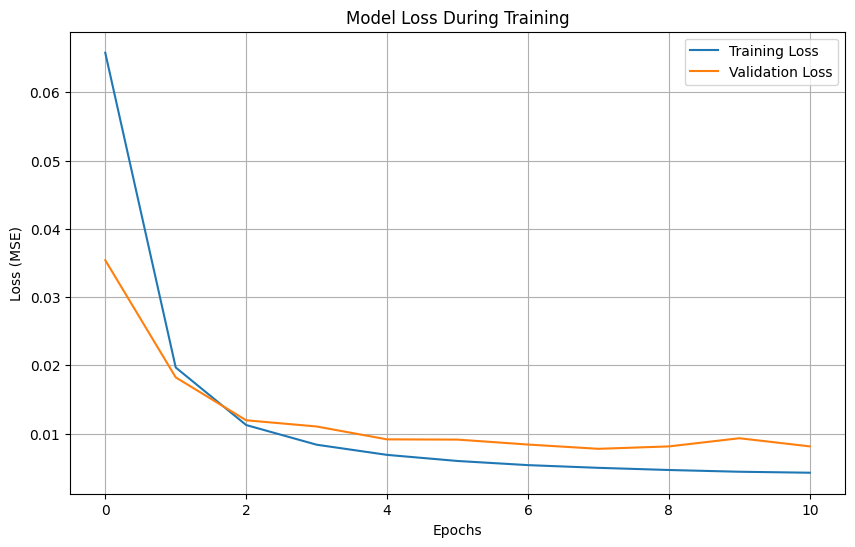

In [ ]:

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Make predictions on the test set
predictions_scaled = model.predict(X_test_lstm)

# Inverse transform the predictions to the original scale
predictions = scaler_y.inverse_transform(predictions_scaled)

# Ensure predictions do not contain NaN values and convert to integers
predictions = np.nan_to_num(predictions)
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# The row IDs for the submission are simply the datetime index of the test set.
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)


411/411 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step


In [ ]:
# Make predictions on the validation data split used in the last training fold
val_predictions_scaled = model.predict(X_val_split)

# Inverse transform the validation predictions to the original scale
val_predictions = scaler_y.inverse_transform(val_predictions_scaled)

# Inverse transform the validation actuals for comparison
y_val_split_original = scaler_y.inverse_transform(y_val_split)

# Calculate RMSE on the validation data
val_rmse = np.sqrt(mean_squared_error(y_val_split_original, val_predictions))

print(f"\nValidation RMSE: {val_rmse}")

160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step

Validation RMSE: 80.46703281869337
